**Cài đặt các thư viện cần thiết**

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.neighbors import BallTree
import osmnx as ox
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

**Get dữ liệu toàn bộ các trạm xe bus ở Tp. Hồ Chí Minh từ OpenStreetMap (OSM)**

In [ ]:
place_name = "Ho Chi Minh City, Vietnam"
tags = {"highway": "bus_stop"}

bus_gdf = ox.features_from_place(place_name, tags=tags)
bus_stops = bus_gdf.reset_index()[["name", "geometry"]].dropna(subset=["geometry"])
bus_stops = bus_stops[bus_stops.geometry.type == "Point"]
bus_stops["lat"] = bus_stops.geometry.y
bus_stops["lon"] = bus_stops.geometry.x

bus_stops.head()
bus_stops.to_excel("all_bus_stops_hcm.xlsx", index=False)
print(f"✅ Đã lưu {len(bus_stops)} trạm xe buýt vào all_bus_stops_hcm.xlsx")

✅ Đã lưu 4754 trạm xe buýt vào all_bus_stops_hcm.xlsx


In [ ]:
bus_real_df = bus_stops
metro_df = pd.read_excel("HCMC_Metro_All_Stations.xlsx")

In [ ]:
# Vẽ bản đồ mạng busmap
G_busmap = nx.Graph()
bus_coords = list(zip(bus_real_df["lon"], bus_real_df["lat"]))
pos_busmap = {i: coord for i, coord in enumerate(bus_coords)}

for i, (lon, lat) in enumerate(bus_coords):
    G_busmap.add_node(i, pos=(lon, lat))

for i in range(len(bus_coords)):
    for j in range(i + 1, len(bus_coords)):
        dist = geodesic((bus_coords[i][1], bus_coords[i][0]), (bus_coords[j][1], bus_coords[j][0])).meters
        if dist < 500:
            G_busmap.add_edge(i, j)

pos_busmap = nx.get_node_attributes(G_busmap, 'pos')

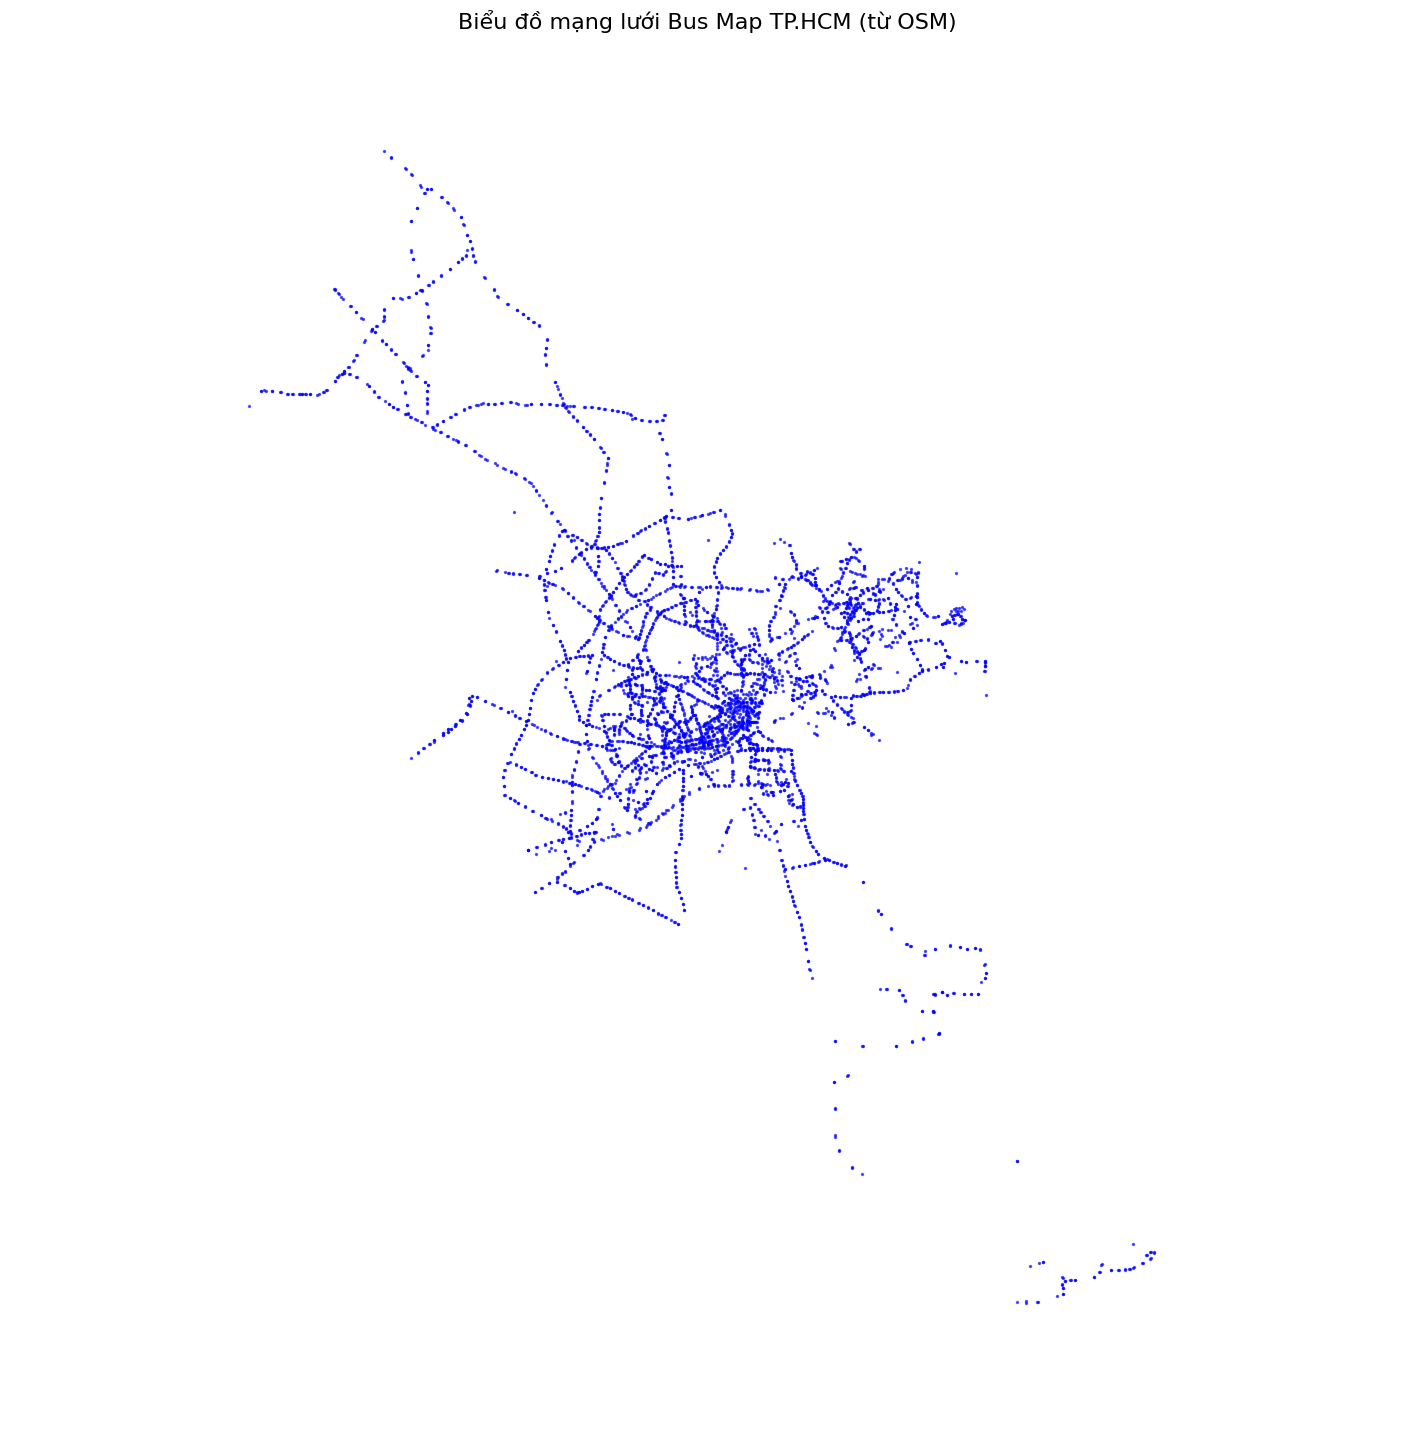

In [ ]:
plt.figure(figsize=(18, 18))
nx.draw_networkx_nodes(G_busmap, pos_busmap, node_size=2, node_color="blue", alpha=0.6)
nx.draw_networkx_edges(G_busmap, pos_busmap, edge_color="lightgray", width=0.2, alpha=0.4)

plt.title("Biểu đồ mạng lưới Bus Map TP.HCM (từ OSM)", fontsize=16)
plt.axis("equal")
plt.axis("off")
plt.show()

In [ ]:
bus_coords_rad = np.radians(bus_real_df[["lat", "lon"]].dropna().values)
metro_coords_rad = np.radians(metro_df[["Latitude", "Longitude"]].dropna().values)
tree = BallTree(metro_coords_rad, metric="haversine")
radius = 1.0 / 6371.0
indices = tree.query_radius(bus_coords_rad, r=radius)
is_overlap = np.array([len(match) > 0 for match in indices])
bus_real_df["overlap_metro"] = is_overlap
bus_cleaned_df = bus_real_df[bus_real_df["overlap_metro"] == False].copy()

In [ ]:
tree_full = BallTree(metro_coords_rad, metric="haversine")
distances, nearest_idx = tree_full.query(bus_coords_rad, k=1)
bus_real_df["assigned_metro"] = [metro_df.iloc[i]["Station"] for i in nearest_idx.flatten()]
bus_cleaned_df = bus_real_df[bus_real_df["overlap_metro"] == False].copy()

**Suy ra geopoint tương đối của metro**

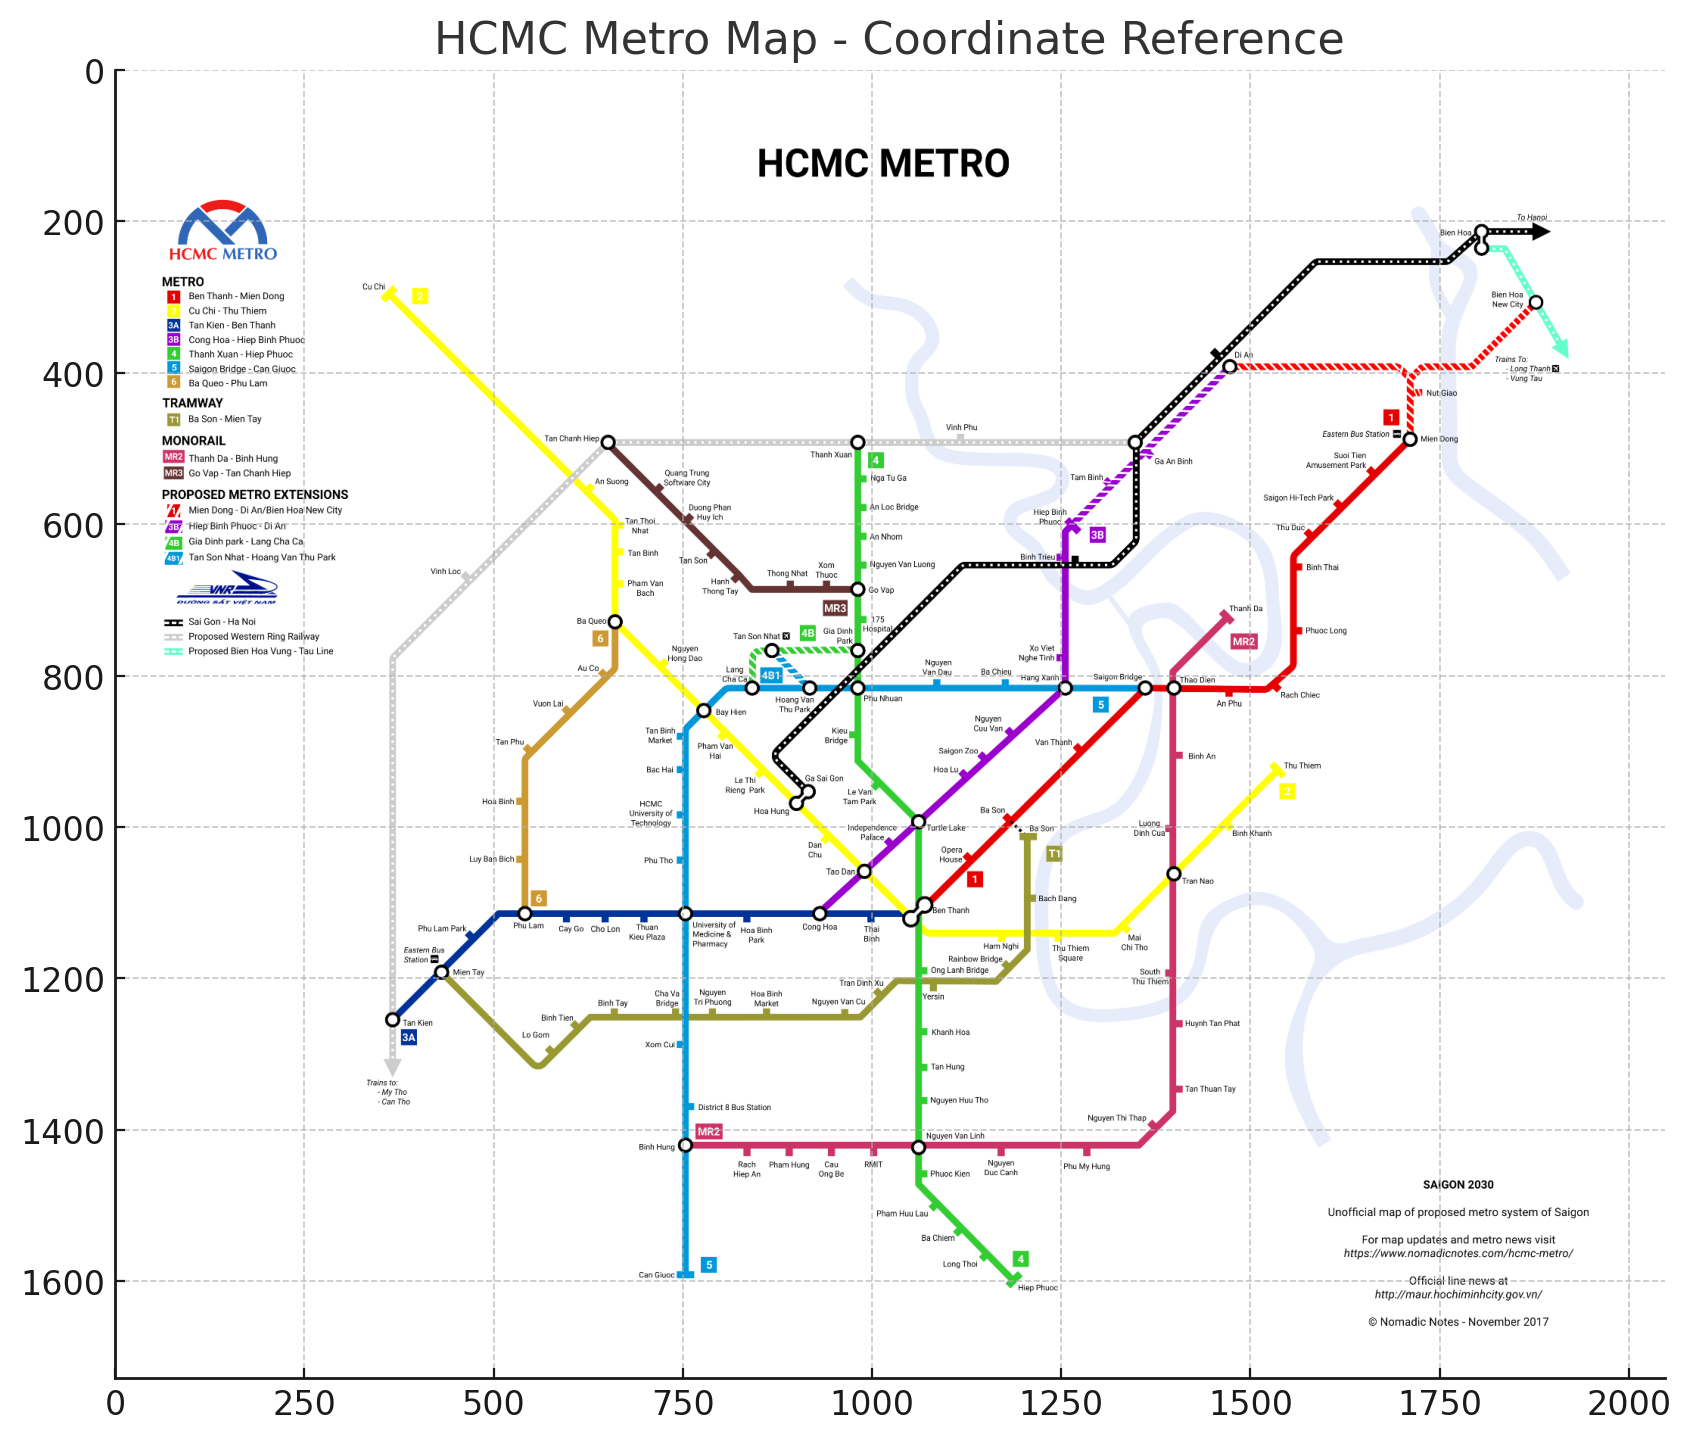

In [ ]:
# Khởi tạo bảng mẫu tuyến Metro (Line, Station, Latitude, Longitude, Order)
# Line M1

metro_lines_data = [
    # Line M1: Bến Thành – Suối Tiên
    ("M1", "Ben Thanh", 10.7720, 106.6985, 1),
    ("M1", "Opera House", 10.7796, 106.7050, 2),
    ("M1", "Ba Son", 10.7913, 106.7097, 3),
    ("M1", "Van Thanh", 10.8020, 106.7160, 4),
    ("M1", "Tan Cang", 10.8093, 106.7212, 5),
    ("M1", "Thao Dien", 10.8125, 106.7350, 6),
    ("M1", "An Phu", 10.8128, 106.7483, 7),
    ("M1", "Rach Chiec", 10.8122, 106.7656, 8),
    ("M1", "Thu Duc", 10.8228, 106.7776, 9),
    ("M1", "Binh Thai", 10.8332, 106.7849, 10),
    ("M1", "High-Tech Park", 10.8457, 106.7943, 11),
    ("M1", "New Mien Dong", 10.8530, 106.8000, 12),
]


metro_df_m1 = pd.DataFrame(metro_lines_data, columns=["Line", "Station", "Latitude", "Longitude", "Order"])
metro_df_m1.head(12)

,Line,Station,Latitude,Longitude,Order
0,M1,Ben Thanh,10.7720,106.6985,1
1,M1,Opera House,10.7796,106.7050,2
2,M1,Ba Son,10.7913,106.7097,3
3,M1,Van Thanh,10.8020,106.7160,4
4,M1,Tan Cang,10.8093,106.7212,5
5,M1,Thao Dien,10.8125,106.7350,6
6,M1,An Phu,10.8128,106.7483,7
7,M1,Rach Chiec,10.8122,106.7656,8
8,M1,Thu Duc,10.8228,106.7776,9
9,M1,Binh Thai,10.8332,106.7849,10


In [ ]:
# M2 – Bến Thành – Tham Lương
metro_m2 = [
    ("M2", "Ben Thanh", 10.7720, 106.6985, 1),
    ("M2", "Nguyen Hue", 10.7747, 106.7007, 2),
    ("M2", "Nguyen Thi Minh Khai", 10.7775, 106.6964, 3),
    ("M2", "Dan Chu", 10.7844, 106.6846, 4),
    ("M2", "Ba Thang Hai", 10.7859, 106.6731, 5),
    ("M2", "Thanh Thai", 10.7936, 106.6677, 6),
    ("M2", "Pham Van Bach", 10.8044, 106.6429, 7),
    ("M2", "Tham Luong", 10.8218, 106.6223, 8),
]

# M3A – Ben Thanh – Tan Kien
metro_m3a = [
    ("M3A", "Ben Thanh", 10.7720, 106.6985, 1),
    ("M3A", "Nguyen Thai Hoc", 10.7660, 106.6897, 2),
    ("M3A", "Nguyen Van Cu", 10.7618, 106.6841, 3),
    ("M3A", "Ly Thai To", 10.7575, 106.6768, 4),
    ("M3A", "Ba Hat", 10.7561, 106.6671, 5),
    ("M3A", "Lac Long Quan", 10.7528, 106.6584, 6),
    ("M3A", "Tan Hoa", 10.7475, 106.6496, 7),
    ("M3A", "Tan Kien", 10.7400, 106.6030, 8),
]

# M3B – Cong Vien Gia Dinh – Hiep Binh Phuoc
metro_m3b = [
    ("M3B", "Cong Vien Gia Dinh", 10.8168, 106.6778, 1),
    ("M3B", "Pham Van Dong", 10.8203, 106.6893, 2),
    ("M3B", "Vo Van Ngan", 10.8318, 106.7041, 3),
    ("M3B", "Hiep Binh Chanh", 10.8412, 106.7096, 4),
    ("M3B", "Hiep Binh Phuoc", 10.8530, 106.7155, 5),
]


metro_df_m23 = pd.DataFrame(metro_m2 + metro_m3a + metro_m3b, columns=["Line", "Station", "Latitude", "Longitude", "Order"])
metro_full_extended = pd.concat([metro_df_m1, metro_df_m23], ignore_index=True)
metro_full_extended.head(15)

,Line,Station,Latitude,Longitude,Order
0,M1,Ben Thanh,10.7720,106.6985,1
1,M1,Opera House,10.7796,106.7050,2
2,M1,Ba Son,10.7913,106.7097,3
3,M1,Van Thanh,10.8020,106.7160,4
4,M1,Tan Cang,10.8093,106.7212,5
5,M1,Thao Dien,10.8125,106.7350,6
6,M1,An Phu,10.8128,106.7483,7
7,M1,Rach Chiec,10.8122,106.7656,8
8,M1,Thu Duc,10.8228,106.7776,9
9,M1,Binh Thai,10.8332,106.7849,10


In [ ]:
# M4 – Thạnh Xuân → Nguyễn Văn Linh
metro_m4 = [
    ("M4", "Thạnh Xuân", 10.8731, 106.6603, 1),
    ("M4", "Quang Trung", 10.8555, 106.6530, 2),
    ("M4", "Pham Van Chieu", 10.8448, 106.6514, 3),
    ("M4", "Phan Van Tri", 10.8384, 106.6662, 4),
    ("M4", "Le Quang Dinh", 10.8296, 106.6807, 5),
    ("M4", "Nguyen Van Cu", 10.8105, 106.6905, 6),
    ("M4", "Nguyen Van Linh", 10.7502, 106.7033, 7),
]

# M5 – Bay Hien – Can Giuoc
metro_m5 = [
    ("M5", "Bay Hien", 10.7975, 106.6521, 1),
    ("M5", "Pham Van Bach", 10.8050, 106.6432, 2),
    ("M5", "Tan Phu", 10.7968, 106.6351, 3),
    ("M5", "Tan Hoa", 10.7790, 106.6313, 4),
    ("M5", "Binh Tan", 10.7663, 106.6265, 5),
    ("M5", "Can Giuoc", 10.7400, 106.6175, 6),
]

# T1 – Tramway: Saigon Zoo – Mien Tay
tram_t1 = [
    ("T1", "Saigon Zoo", 10.7890, 106.7072, 1),
    ("T1", "Nguyen Binh Khiem", 10.7851, 106.7100, 2),
    ("T1", "Ton Duc Thang", 10.7778, 106.7120, 3),
    ("T1", "Nguyen Thai Hoc", 10.7684, 106.6910, 4),
    ("T1", "Tran Hung Dao", 10.7633, 106.6770, 5),
    ("T1", "Nguyen Van Cu", 10.7581, 106.6620, 6),
    ("T1", "Mien Tay", 10.7463, 106.6273, 7),
]

# MR1 – Monorail: Cong Hoa – Saigon South
monorail_mr1 = [
    ("MR1", "Cong Hoa", 10.7971, 106.6527, 1),
    ("MR1", "Truong Chinh", 10.7911, 106.6393, 2),
    ("MR1", "Tan Son Nhat", 10.8103, 106.6640, 3),
    ("MR1", "Nguyen Van Troi", 10.8004, 106.6768, 4),
    ("MR1", "Nguyen Huu Tho", 10.7540, 106.6940, 5),
    ("MR1", "Saigon South", 10.7382, 106.7003, 6),
]


metro_additional_df = pd.DataFrame(
    metro_m4 + metro_m5 + tram_t1 + monorail_mr1,
    columns=["Line", "Station", "Latitude", "Longitude", "Order"]
)


metro_full_all = pd.concat([metro_full_extended, metro_additional_df], ignore_index=True)
metro_full_all.tail(15)

,Line,Station,Latitude,Longitude,Order
44,M5,Binh Tan,10.7663,106.6265,5
45,M5,Can Giuoc,10.7400,106.6175,6
46,T1,Saigon Zoo,10.7890,106.7072,1
47,T1,Nguyen Binh Khiem,10.7851,106.7100,2
48,T1,Ton Duc Thang,10.7778,106.7120,3
49,T1,Nguyen Thai Hoc,10.7684,106.6910,4
50,T1,Tran Hung Dao,10.7633,106.6770,5
51,T1,Nguyen Van Cu,10.7581,106.6620,6
52,T1,Mien Tay,10.7463,106.6273,7
53,MR1,Cong Hoa,10.7971,106.6527,1


<ipython-input-14-5f0fe4afae4f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(lines_all))


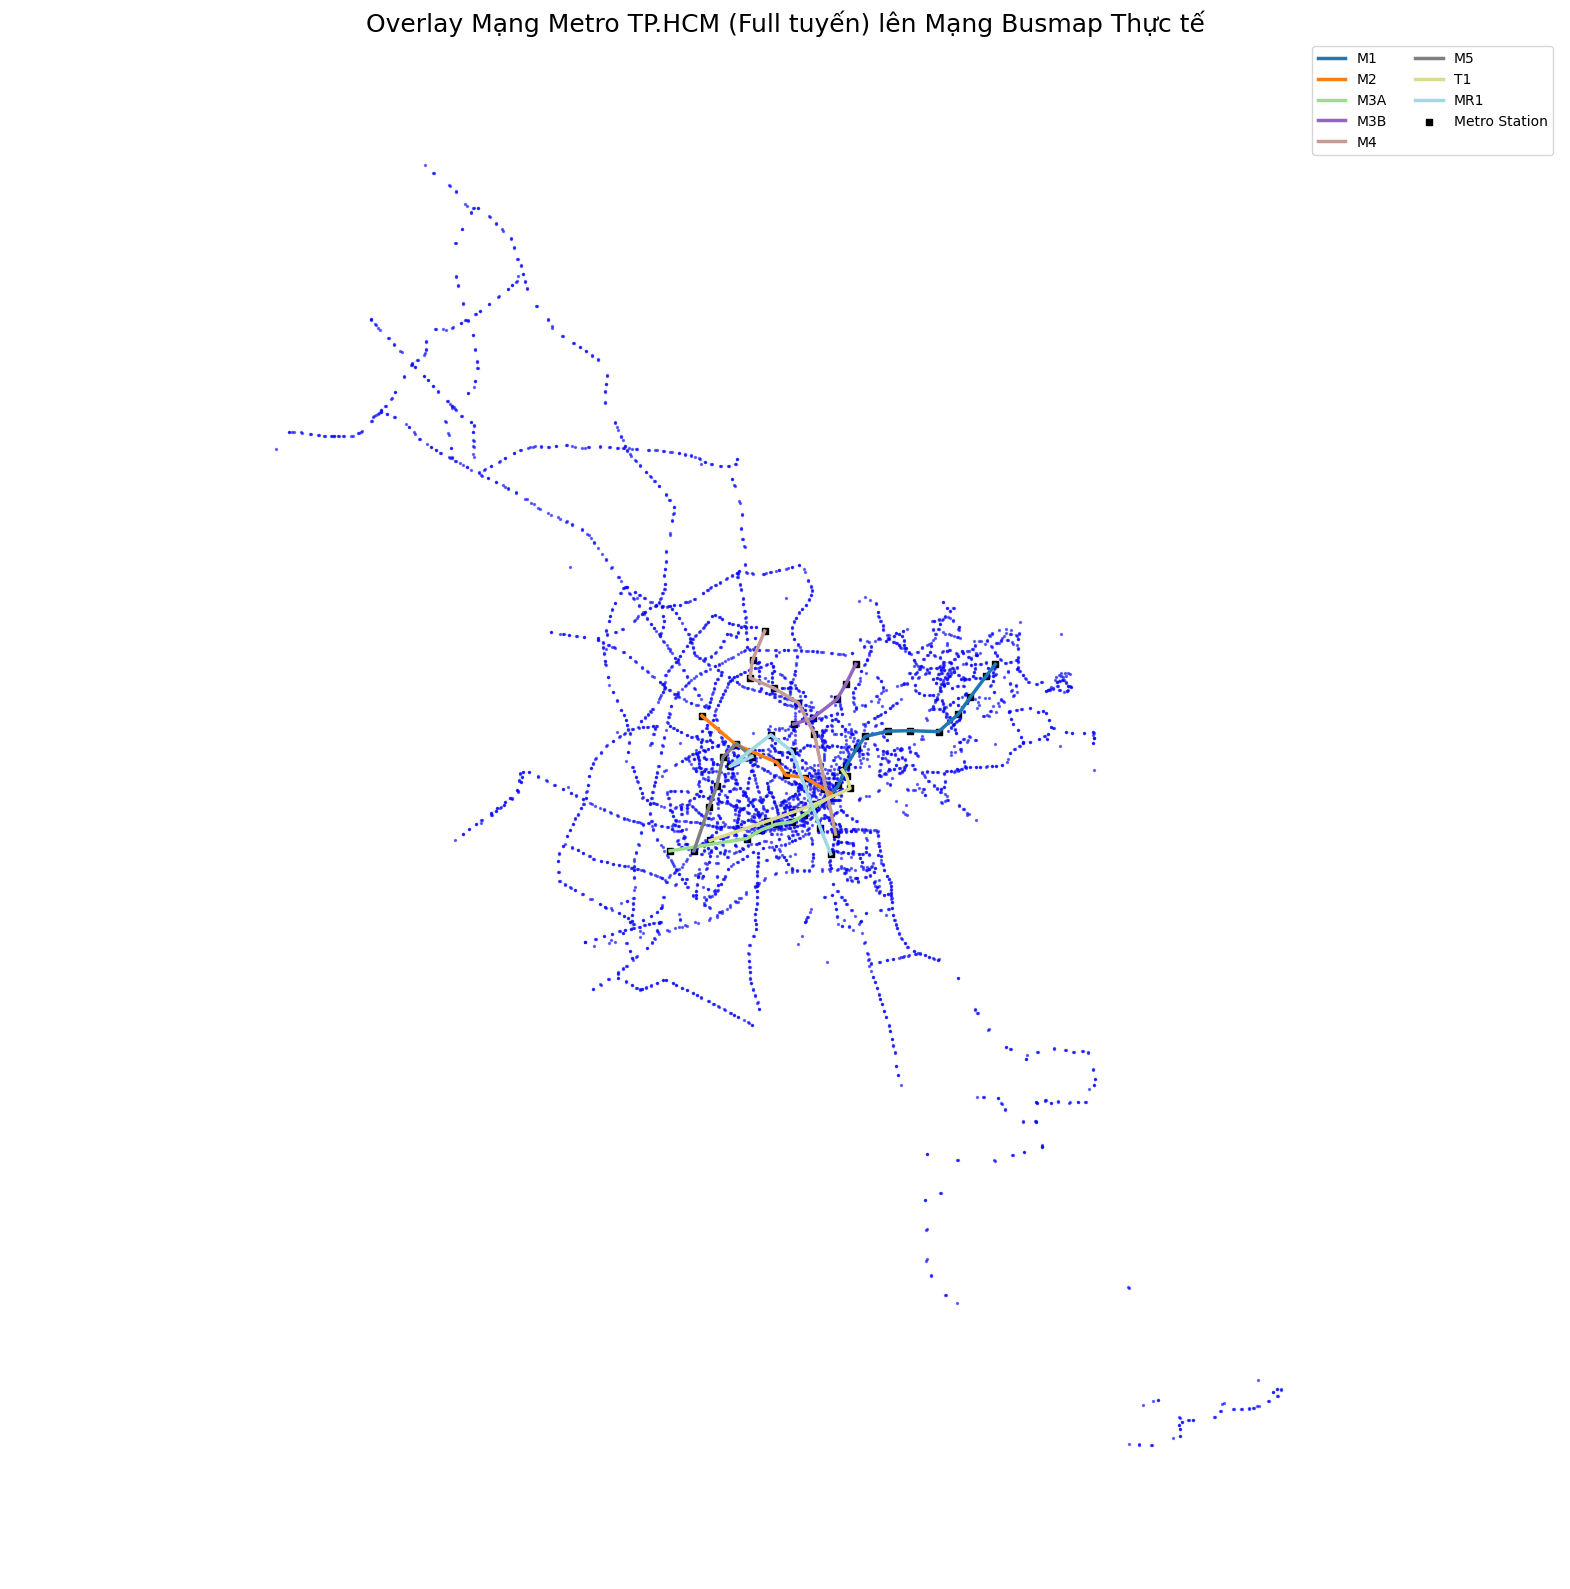

In [ ]:
plt.figure(figsize=(20, 20))

# Bản đồ mạng bus
nx.draw_networkx_nodes(G_busmap, pos_busmap, node_size=2, node_color="blue", alpha=0.5)
nx.draw_networkx_edges(G_busmap, pos_busmap, edge_color="lightgray", width=0.3, alpha=0.3)

lines_all = metro_full_all["Line"].unique()
cmap = cm.get_cmap("tab20", len(lines_all))
color_dict = {line: mcolors.to_hex(cmap(i)) for i, line in enumerate(lines_all)}

# Vẽ bản đồ Metro
for line in lines_all:
    subline = metro_full_all[metro_full_all["Line"] == line].sort_values(by="Order")
    if subline.shape[0] > 1:
        latlons = list(zip(subline["Longitude"], subline["Latitude"]))
        x, y = zip(*latlons)
        plt.plot(x, y, color=color_dict[line], linewidth=2.5, label=f"{line}")

plt.scatter(metro_full_all["Longitude"], metro_full_all["Latitude"], color="black", s=20, marker='s', label="Metro Station")
plt.title("Overlay Mạng Metro TP.HCM (Full tuyến) lên Mạng Busmap Thực tế", fontsize=18)
plt.legend(loc="upper right", fontsize=10, ncol=2)
plt.axis("equal")
plt.axis("off")
plt.show()

**Busmap rearrange**

In [ ]:
# Bước 1: chuẩn hoá trạm bus (loại overlap)
bus_coords_rad = np.radians(bus_real_df[["lat", "lon"]].dropna().values)
metro_coords_rad = np.radians(metro_full_all[["Latitude", "Longitude"]].dropna().values)

tree = BallTree(metro_coords_rad, metric="haversine")
radius_1km = 1.0 / 6371.0  # 1km in radians

indices = tree.query_radius(bus_coords_rad, r=radius_1km)
is_overlap = np.array([len(match) > 0 for match in indices])

# Loại trạm bus trùng metro (trong 1km)
bus_real_df["overlap_metro"] = is_overlap
bus_cleaned_df = bus_real_df[bus_real_df["overlap_metro"] == False].copy()

# Gán lại Metro gần nhất
tree_full = BallTree(metro_coords_rad, metric="haversine")
distances, nearest_idx = tree_full.query(bus_coords_rad, k=1)
bus_real_df["assigned_metro"] = [metro_full_all.iloc[i]["Station"] for i in nearest_idx.flatten()]
bus_cleaned_df = bus_real_df[bus_real_df["overlap_metro"] == False].copy()

# Phân tầng Main/Sub
bus_cleaned_df["feeder_level"] = "Sub"
for metro in bus_cleaned_df["assigned_metro"].unique():
    group_indices = bus_cleaned_df[bus_cleaned_df["assigned_metro"] == metro].index
    metro_row = metro_full_all[metro_full_all["Station"] == metro]
    if not metro_row.empty and not group_indices.empty:
        metro_lat = metro_row.iloc[0]["Latitude"]
        metro_lon = metro_row.iloc[0]["Longitude"]
        distances = bus_cleaned_df.loc[group_indices].apply(
            lambda row: geodesic((row["lat"], row["lon"]), (metro_lat, metro_lon)).meters, axis=1
        )
        main_idx = distances.idxmin()
        bus_cleaned_df.loc[main_idx, "feeder_level"] = "Main"
bus_cleaned_df.to_excel("bus_df_cleaned.xlsx", index=False)
print(f"✅ Đã lưu {len(bus_cleaned_df)} trạm mới")

✅ Đã lưu 3328 trạm mới


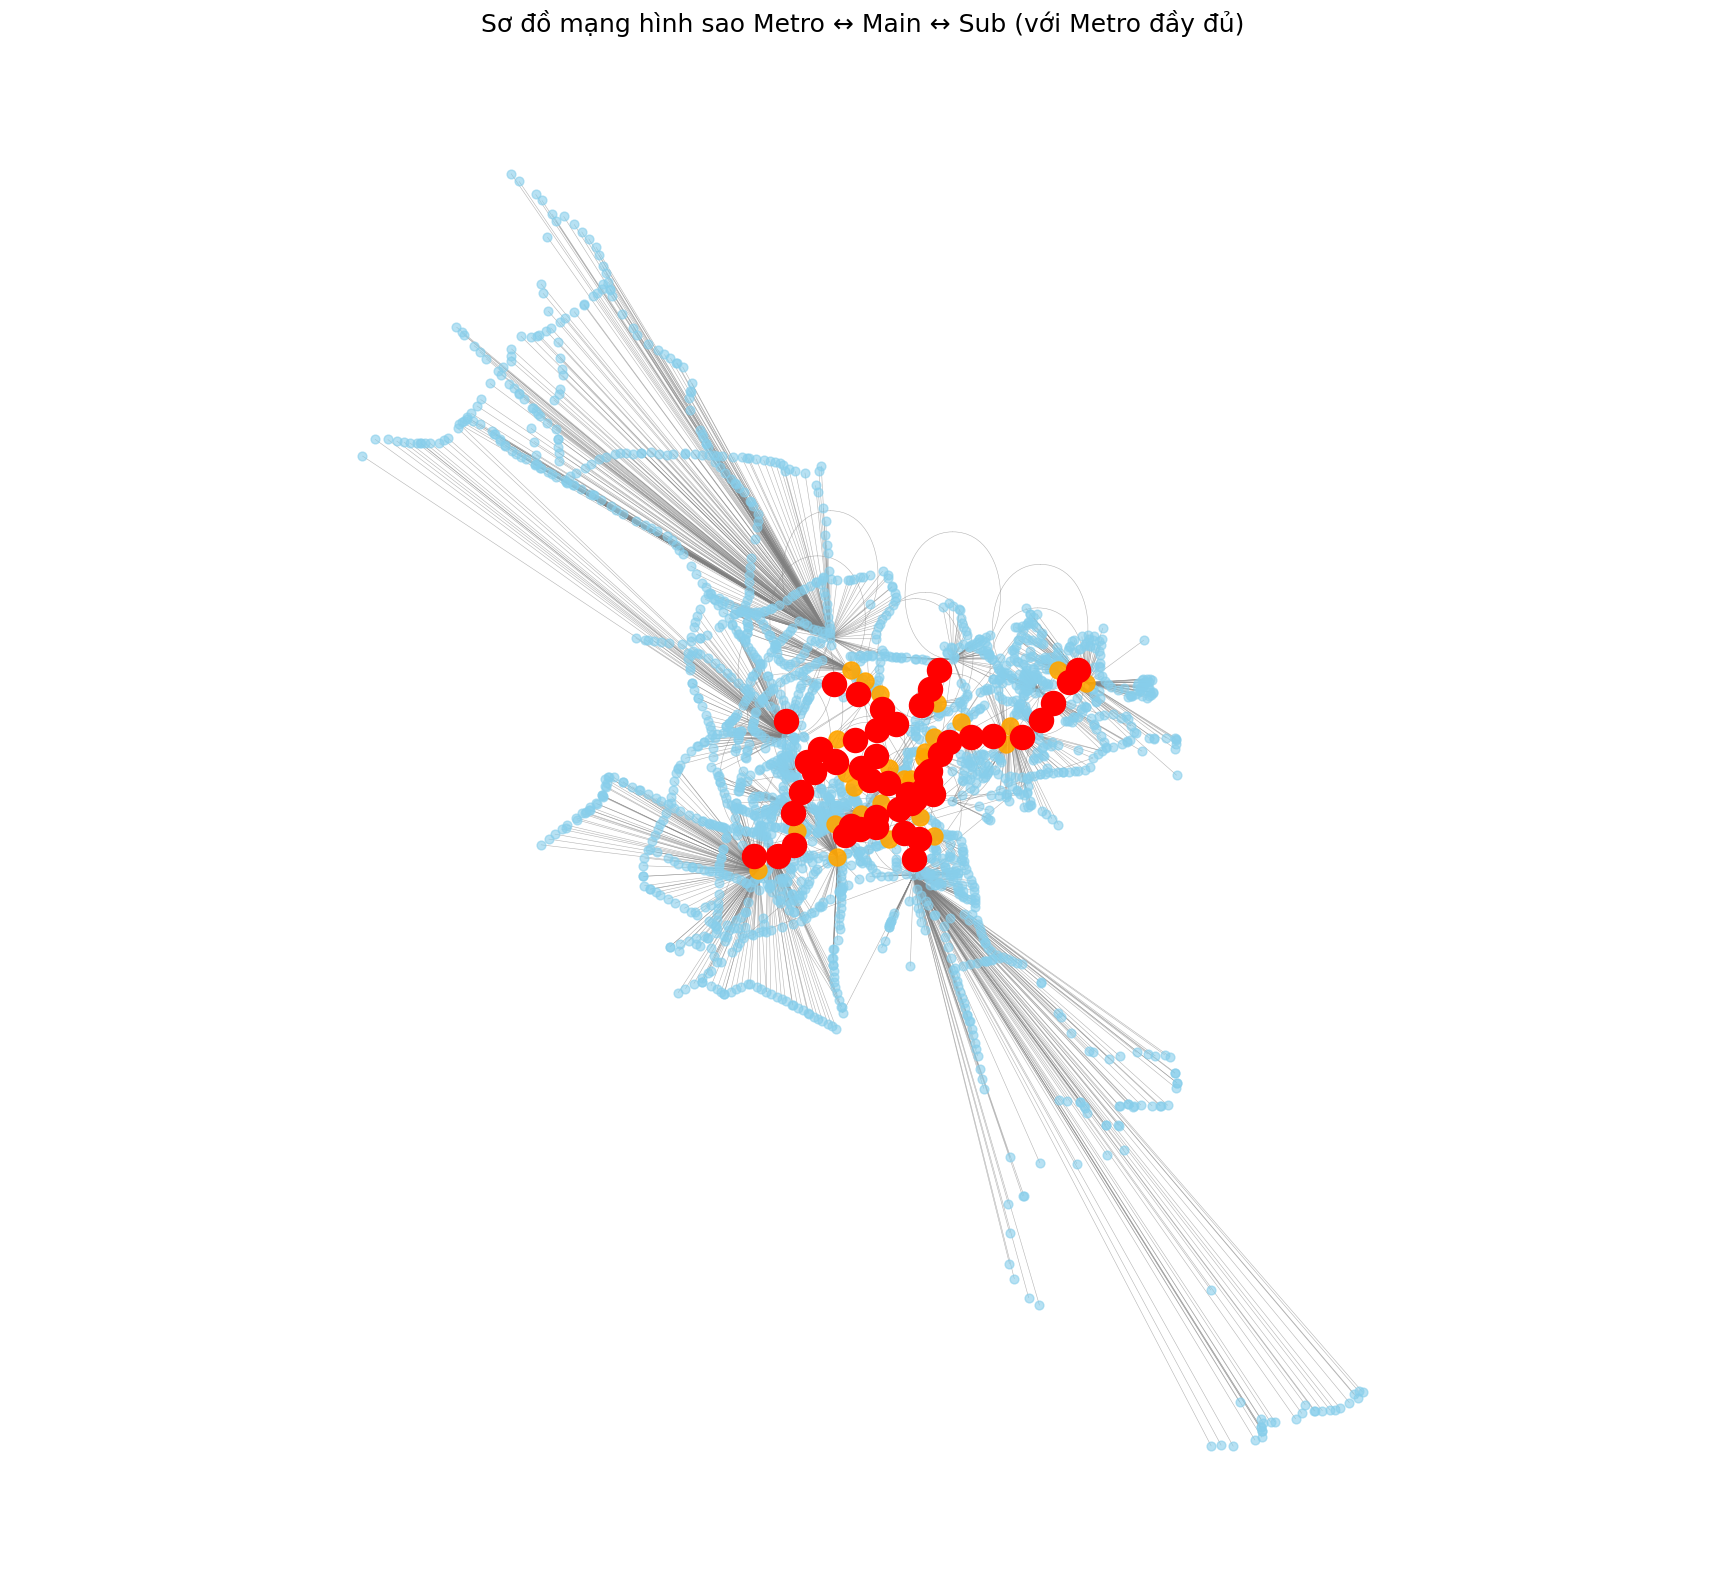

In [ ]:

G_final = nx.Graph()

for _, row in metro_full_all.iterrows():
    G_final.add_node(row["Station"], pos=(row["Longitude"], row["Latitude"]), level="Metro")

# Thêm các cụm feeder: Main ↔ Sub → Metro
for metro in bus_cleaned_df["assigned_metro"].unique():
    group = bus_cleaned_df[bus_cleaned_df["assigned_metro"] == metro]
    metro_pos = metro_full_all[metro_full_all["Station"] == metro][["Longitude", "Latitude"]].iloc[0]

    # Nếu có Main
    main_rows = group[group["feeder_level"] == "Main"]
    if not main_rows.empty:
        main_row = main_rows.iloc[0]
        G_final.add_node(main_row["name"], pos=(main_row["lon"], main_row["lat"]), level="Main")
        G_final.add_edge(metro, main_row["name"])

        for _, sub in group[group["feeder_level"] == "Sub"].iterrows():
            G_final.add_node(sub["name"], pos=(sub["lon"], sub["lat"]), level="Sub")
            G_final.add_edge(main_row["name"], sub["name"])

# Vẽ bản đồ mạng
pos_final = nx.get_node_attributes(G_final, 'pos')
level_final = nx.get_node_attributes(G_final, 'level')
color_map = {"Metro": "red", "Main": "orange", "Sub": "skyblue"}
node_colors = [color_map[level_final[n]] for n in G_final.nodes]
node_sizes = [300 if level_final[n] == 'Metro' else (150 if level_final[n] == 'Main' else 40) for n in G_final.nodes]

plt.figure(figsize=(22, 20))

sub_nodes = [n for n in G_final.nodes if level_final[n] == "Sub"]
nx.draw_networkx_nodes(G_final, pos_final, nodelist=sub_nodes, node_color="skyblue", node_size=40, alpha=0.6)

main_nodes = [n for n in G_final.nodes if level_final[n] == "Main"]
nx.draw_networkx_nodes(G_final, pos_final, nodelist=main_nodes, node_color="orange", node_size=150, alpha=0.9)

metro_nodes = [n for n in G_final.nodes if level_final[n] == "Metro"]
nx.draw_networkx_nodes(G_final, pos_final, nodelist=metro_nodes, node_color="red", node_size=300, alpha=1.0)

nx.draw_networkx_edges(G_final, pos_final, edge_color="gray", width=0.4, alpha=0.6)

plt.title("Sơ đồ mạng hình sao Metro ↔ Main ↔ Sub (với Metro đầy đủ)", fontsize=18)
plt.axis("equal")
plt.axis("off")
plt.show()


In [ ]:
# So sánh số lượng trạm bus ban đầu và sau khi loại overlap với metro
original_count = bus_real_df.shape[0]
cleaned_count = bus_cleaned_df.shape[0]
removed_count = original_count - cleaned_count

original_count, cleaned_count, removed_count

(4754, 3328, 1426)

In [ ]:
# Bước 1: Tính các chỉ số PageRank và Degree Centrality từ đồ thị G_final
degree_centrality = nx.degree_centrality(G_final)
pagerank = nx.pagerank(G_final)

# Bước 2: Tạo DataFrame chứa thông tin và tính toán ngưỡng
centrality_df = pd.DataFrame({
    "node": list(G_final.nodes),
    "degree": [degree_centrality[n] for n in G_final.nodes],
    "pagerank": [pagerank[n] for n in G_final.nodes],
    "level": [G_final.nodes[n]['level'] for n in G_final.nodes]
})

# Bước 3: Tính các ngưỡng thống kê (median và percentile 75)
thresholds = {
    "degree_median": centrality_df["degree"].median(),
    "degree_75": centrality_df["degree"].quantile(0.75),
    "pagerank_median": centrality_df["pagerank"].median(),
    "pagerank_75": centrality_df["pagerank"].quantile(0.75)
}

centrality_df.head(), thresholds

(          node    degree  pagerank  level
 0    Ben Thanh  0.000489  0.000310  Metro
 1  Opera House  0.000000  0.000074  Metro
 2       Ba Son  0.000489  0.000491  Metro
 3    Van Thanh  0.000489  0.000265  Metro
 4     Tan Cang  0.000489  0.000290  Metro,
 {'degree_median': 0.0004894762604013706,
  'degree_75': np.float64(0.0004894762604013706),
  'pagerank_median': 0.00026076651457905857,
  'pagerank_75': np.float64(0.00026257279680732464)})

*Chỉ số Degree Median và Q3 đều là 0.00049188 - trùng nhau -> Phân phối đều*

In [ ]:
degree_threshold = thresholds["degree_median"]
pagerank_threshold = thresholds["pagerank_75"]

centrality_df["reason_keep"] = "Filtered"
centrality_df.loc[
    (centrality_df["pagerank"] >= pagerank_threshold) & (centrality_df["degree"] < degree_threshold),
    "reason_keep"
] = "High PageRank"
centrality_df.loc[
    (centrality_df["degree"] >= degree_threshold) & (centrality_df["pagerank"] < pagerank_threshold),
    "reason_keep"
] = "High Degree"
centrality_df.loc[
    (centrality_df["degree"] >= degree_threshold) & (centrality_df["pagerank"] >= pagerank_threshold),
    "reason_keep"
] = "High Both"

nx.set_node_attributes(G_final, centrality_df.set_index("node")["reason_keep"].to_dict(), "reason_keep")

nodes_to_keep = centrality_df[centrality_df["reason_keep"] != "Filtered"]["node"].tolist()
G_filtered = nx.Graph()

for u, v in G_final.edges():
    if u in nodes_to_keep and v in nodes_to_keep:
        if u not in G_filtered:
            G_filtered.add_node(u, **G_final.nodes[u])
        if v not in G_filtered:
            G_filtered.add_node(v, **G_final.nodes[v])
        G_filtered.add_edge(u, v)

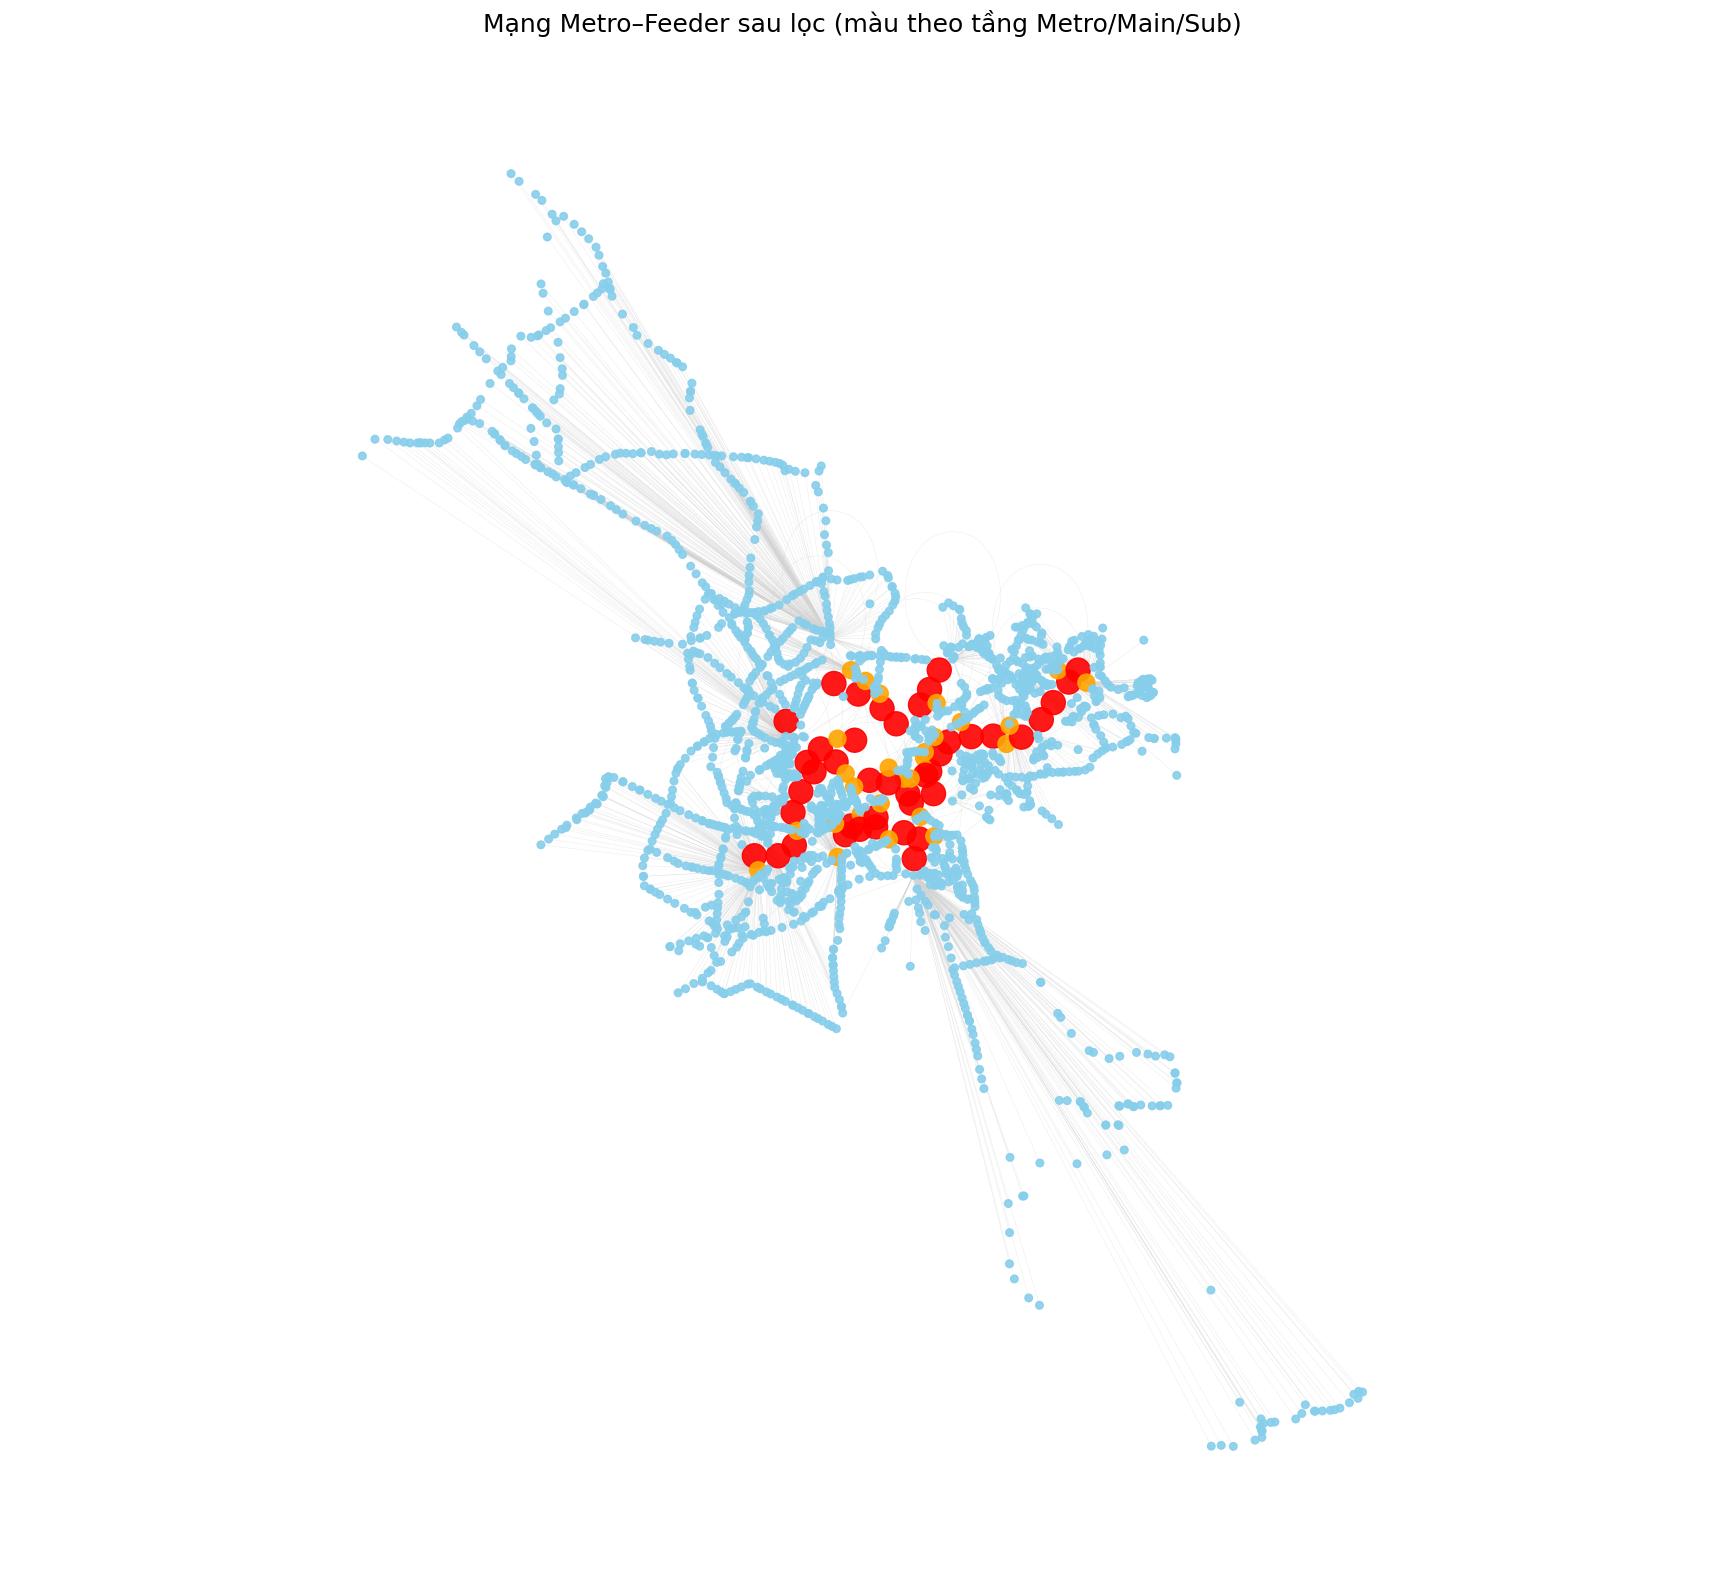

In [ ]:
pos = nx.get_node_attributes(G_filtered, "pos")
level = nx.get_node_attributes(G_filtered, "level")
color_map_level = {"Metro": "red", "Main": "orange", "Sub": "skyblue"}

node_colors = [color_map_level[level[n]] for n in G_filtered.nodes]
node_sizes = [300 if level[n] == 'Metro' else (150 if level[n] == 'Main' else 30) for n in G_filtered.nodes]

plt.figure(figsize=(22, 20))
nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G_filtered, pos, edge_color="lightgray", width=0.3, alpha=0.5)
plt.title("Mạng Metro–Feeder sau lọc (màu theo tầng Metro/Main/Sub)", fontsize=18)
plt.axis("equal")
plt.axis("off")
plt.show()

In [ ]:
# Tính tổng số trạm giữ lại sau khi lọc Centrality (chỉ tính các trạm Main và Sub)
final_kept_count = sum(1 for _, d in G_filtered.nodes(data=True) if d['level'] in ['Main', 'Sub'])

# So sánh với số trạm sau khi loại overlap
original_cleaned_count = bus_cleaned_df.shape[0]
reduced_after_centrality = original_cleaned_count - final_kept_count

original_cleaned_count, final_kept_count, reduced_after_centrality

(3328, 1994, 1334)

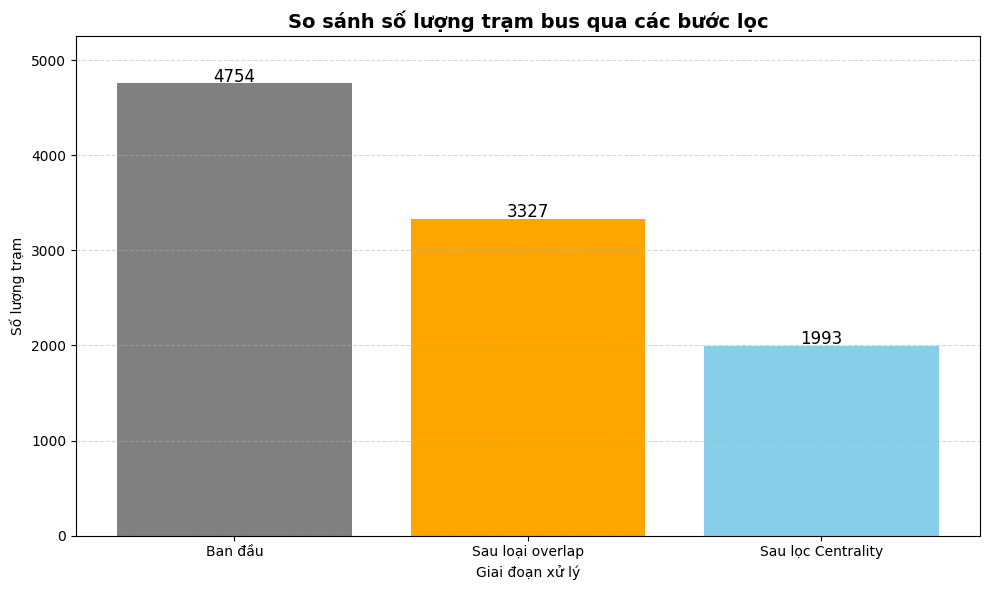

In [ ]:
# Dữ liệu số lượng trạm qua từng bước
stages = ["Ban đầu", "Sau loại overlap", "Sau lọc Centrality"]
values = [4754, 3327, 1993]

plt.figure(figsize=(10, 6))
bars = plt.bar(stages, values, color=["gray", "orange", "skyblue"])
plt.title("So sánh số lượng trạm bus qua các bước lọc", fontsize=14, fontweight="bold")
plt.ylabel("Số lượng trạm")
plt.xlabel("Giai đoạn xử lý")
plt.ylim(0, max(values) + 500)

# Data label
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 20, f"{height}", ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
stats_comparison = {
    "Bước": ["Ban đầu", "Sau loại overlap", "Sau lọc Centrality"],
    "Số nút": [4754, 3327, G_filtered.number_of_nodes()],
    "Số cạnh": ["-", "-", G_filtered.number_of_edges()],
}
#Sau lọc Centrality    2034 nút    2089 cạnh